# Travelling Salesman Problem

The Travelling Salesman Problem, TSP, describes a scenario where a salesman wishes to visit a list of cities, taking the shortest possible route, before returning home to the start point. While it may appear simple, this problem not only has no known polynomial time solution, but there is also no time-efficient way to prove that a given solution is in fact optimal.

The difficulty of this problem increases quickly with the number of nodes in the network we are considering.

| Total Number of Vertices | Number of Possible Routes|
|:------------------------:|:------------------------:|
|4| 3|
|5|12|
|6|60|
|10|1811440|
|12|19,958,400|
|20|6.1x10^16|

In this notebook, we will build some tools to help us create and visualise graphs, implement a Nearest Neighbour approach to solving the TSP, and then explore a Genetic Algorihtm method for producing better results.

## Graph Construction - Defining The Problem

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

# given a distance matrix and a list of node labels, construct a visualisation of the graph described
def draw_graph(node_labels, dist_matrix):

    # take subset of the node labels that are relevant for this graph
    node_labels = {i: node_labels[i] for i in range(dist_matrix.shape[0])}
    
    # convert to integers for better readability
    dist_matrix = np.array(dist_matrix, dtype=int)

    # construct graph from matrix
    G = nx.from_numpy_array(dist_matrix)

    # define layout - nodes around perimeter of a circle    
    pos=nx.shell_layout(G)
    
    # draw vertices
    options = {"node_size": 500, "alpha": 0.8, "node_color": "tab:blue"}
    nx.draw_networkx_nodes(G, pos, **options)
    
    options = {"font_size": 15, "font_color": "whitesmoke"}
    nx.draw_networkx_labels(G, pos, node_labels, **options)
    
    # draw edges
    options = {"width": 1, "edge_color": "tab:gray", "alpha":0.5}
    nx.draw_networkx_edges(G, pos, **options)
    
    options = {"font_size": 7, "font_color": "black", "label_pos": 0.42}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), **options)

    # display graph
    plt.axis('off')
    plt.savefig("Graph.png") # save as png
    plt.show()


In [21]:

# build a distance matrix given the number of nodes
# we populate this matrix with random values
# ensure it is symmetric, and with zeros on the leading diagonal
def generate_graph(num_nodes):

    # matrix of zeros
    m = np.zeros((num_nodes, num_nodes))
    
    # populate with random values
    for i in range(num_nodes):
        for j in range(i):
            rand = random.randint(2, 30)
            m[i][j] = rand
            m[j][i] = rand

    return m

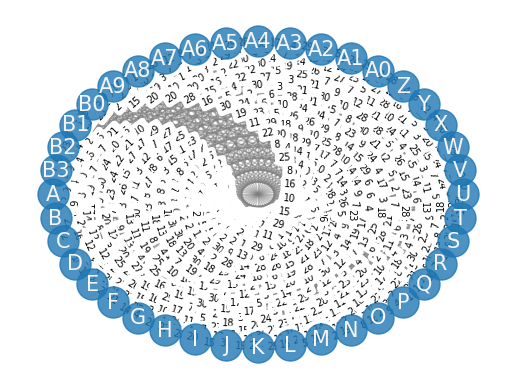

Graph generated for 40 nodes.


In [30]:
# support for up to N nodes by generating labels dynamically
def generate_labels(num_nodes):
    labels = {}
    for i in range(num_nodes):
        if i < 26:
            # From A to Z
            labels[i] = chr(65 + i)
        else:
            # After Z, use A1, B1, C1, etc.
            # (A small fix from my previous code to make it more readable)
            labels[i] = f"{chr(65 + (i-26)//10)}{(i-26)%10}" 
    return labels

# We'll use 40 here as well for the graph test
num_nodes_test = 40 
node_labels = generate_labels(num_nodes_test)
m = generate_graph(num_nodes_test)

# The graph is turned on again as requested
# (Warning: the image might be very messy)
draw_graph(node_labels, m) 
print("Graph generated for 40 nodes.")

## Nearest Neighbour Algorithm

The Nearest Neighbour Algorithm involves repeatedly adding the lowest cost edge that is incident to the previously added node. After visiting all nodes, we return to the start to give us the complete route.

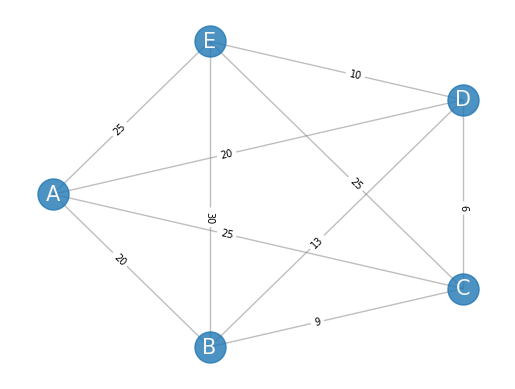

['A', 'B', 'C', 'D', 'E', 'A']
70


In [23]:
# implement the Nearest Neighbour algorihtm 
def nearest_neighbour(distance_matrix):
    
    # distance matrix, m
    m = distance_matrix.copy()

    # start node (and end node)
    start = previous = 0

    # number of nodes
    nodes = m.shape[0]
    
    # overwrite the row corresponding to the previously chosen node (so it cannot be visited again)
    m[previous, :] = [np.inf for i in range(nodes)]
    
    # output variables
    tour = [previous]
    total_cost = 0

    # repeatedly find the cheapest node that connects to the previously chosen node
    # repeat until all nodes have been visited, then return to the start
    for i in range(nodes-1):
        nearest = np.argmin(m[:, previous]) # check the column corresponding to the previously chosen node, find the nearest adjacent node
        tour += [nearest] # add node to route
        total_cost += m[nearest, previous] # add cost to total
    
        previous = nearest
        m[nearest, :] = [np.inf for i in range(nodes)] # overwrite the chosen node from array so it cannot be visited again

    # return to the start
    total_cost += distance_matrix[start, previous]
    tour += [start]
    
    return(tour, int(total_cost))


### TESTING ###

m = generate_graph(5)
draw_graph(node_labels, m)

tour, cost = nearest_neighbour(m.copy())
tour = [node_labels[i] for i in tour]
print(tour)
print(cost)

## Genetic Algorithm Approach

In [24]:
# build our initial population of chromosomes
# each chromosome describes the sequence in which we visit the nodes of the graph
# we will not include the start (and end) node in our chromosome as this will complicate crossover and mutation
# we will build this population our of random permutations of nodes
def generate_initial_population(num_nodes, pop_size):
    
    nodes = [i for i in range(1, num_nodes)] # list of nodes excluding start node
    population = []
    
    for i in range(pop_size):
        random.shuffle(nodes)
        population.append(nodes.copy())

    return population


# fitness function, evaluates the success of a chromosome
# m is the distance matrix of the graph we are trying to solve for
# the fitness score is the total length of the cycle described by the chromosome
def fitness(chromosome, m):

    score = 0
    
    for i, gene in enumerate(chromosome):
        if i == 0:
            score += m[0, gene] # weight of arc from 0 to x_1
        else:
            score += m[gene, chromosome[i-1]] # weight of arc from x_i-1 to x_i

    score += m[0, chromosome[-1]] # weight of arc from x_n to 0

    return 100/score # take the reciprocol such that higher scores represent better solutions


In [25]:
def genetic_algorithm(population, iterations, selection, crossover, crossover_threshold, mutation, mutation_threshold, elitism):

    pop_size = len(population)
    
    mean_fitness_scores = []
    best_fitness_scores = []

    ### EVALUATE INITIAL POPULATION ###
    fitness_scores = [ fitness(i, m) for i in population]
    
    ### SORT INITIAL POPULATION ###
    order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0] 
    population = [population[i] for i in order]
    fitness_scores = sorted(fitness_scores, reverse=True)

    
    ### GENERATION LOOP ###
    for iter in range(iterations):

        new_pop = copy.deepcopy(population)
        replaced = elitism

        # build new population
        while(replaced < pop_size):
    
            # selection
            index = selection(pop_size, fitness_scores)
            
            # crossover
            if random.random() < crossover_threshold:
                child1, child2 = crossover(population[index[0]].copy(), population[index[1]].copy())
            else:
                child1, child2 = population[index[0]].copy(), population[index[1]].copy()
           
            # mutation
            if random.random() < mutation_threshold:
                child1 = mutation(child1)
            if random.random() < mutation_threshold:
                child2 = mutation(child2)

            # replacement
            new_pop[replaced] = child1
            replaced += 1
            if replaced < pop_size:
                new_pop[replaced] = child2
                replaced += 1
      
        # evaluation
        population = new_pop
        fitness_scores = [fitness(i, m) for i in population]

        # sort population by fitness
        order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0] 
        population = [population[i] for i in order]
        fitness_scores = sorted(fitness_scores, reverse=True)

        # calculate mean and maximum fitness score
        mean_fitness_scores.append(np.mean(fitness_scores))
        best_fitness_scores.append(fitness_scores[0])

    return(mean_fitness_scores, best_fitness_scores, population[0].copy())
    

In [26]:
# roulette wheel selection 
# weighted random selection based on fitness score value
# assumes population is sorted by fitness 
def roulette_wheel_selection(pop_size, fitness_scores):
    return(random.choices(range(pop_size), weights=fitness_scores, k=2))


# replace a random subset of elements in the order in which they appear in the other chromosome
def order_crossover(x1, x2):

    values = np.random.choice(x1, size=3, replace=False) # random choice of values to rearrange
    
    x1_index = [i for i in range(len(x1)) if x1[i] in values] # list of array indices of where the values appear
    x2_index = [i for i in range(len(x1)) if x2[i] in values]

    temp = [i for i in x1 if i in values] # values in the order in which they appear in x1
    
    x1[x1_index[0]], x1[x1_index[1]], x1[x1_index[2]] = x2[x2_index[0]], x2[x2_index[1]], x2[x2_index[2]]
    x2[x2_index[0]], x2[x2_index[1]], x2[x2_index[2]] = temp[0], temp[1], temp[2]
    
    return x1, x2


# swap mutation - swap 2 values in a chromosome
def mutate1(x):
    index = np.random.choice(range(len(x)), size=2, replace=False)
    temp = x[index[0]]
    x[index[0]] = x[index[1]]
    x[index[1]] = temp
    return x

# random insertion - remove a value and re-insert it in a random position in the chromosome
def mutate2(x):
    index = random.choice(range(len(x)))
    temp = x[index]
    x.remove(temp)
    x.insert(random.choice(range(len(x))), temp)
    return x
    

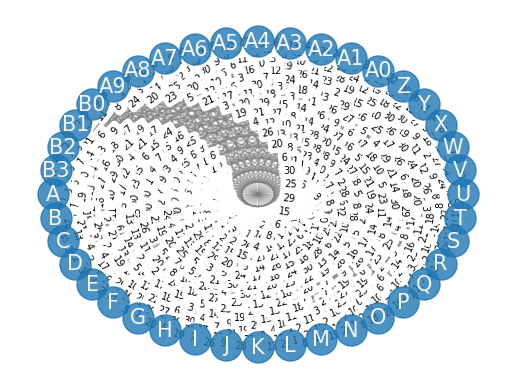

Random Initial Tour: ['A', 'L', 'B0', 'O', 'A7', 'G', 'M', 'J', 'K', 'S', 'U', 'D', 'C', 'A6', 'A3', 'P', 'W', 'F', 'A2', 'X', 'B1', 'Y', 'A1', 'Z', 'N', 'R', 'B3', 'B2', 'A8', 'I', 'A0', 'V', 'B', 'Q', 'A4', 'T', 'E', 'H', 'A5', 'A9', 'A'], Weight: 690.0
Best Tour: ['A', 'Y', 'M', 'A5', 'C', 'A8', 'A2', 'B', 'E', 'U', 'X', 'W', 'F', 'B3', 'B1', 'T', 'A0', 'A1', 'A6', 'J', 'H', 'Z', 'O', 'A3', 'K', 'V', 'R', 'D', 'A4', 'B0', 'I', 'N', 'Q', 'A9', 'L', 'A7', 'S', 'B2', 'G', 'P', 'A'], Weight: 243.0


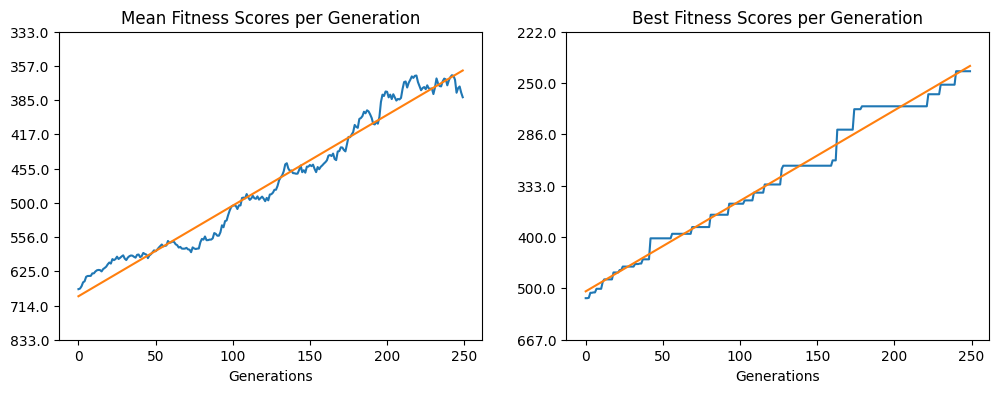


Nearest Neighbour Tour:  ['A', 'M', 'V', 'W', 'F', 'B0', 'E', 'I', 'B2', 'G', 'P', 'A5', 'Q', 'Y', 'A9', 'L', 'J', 'S', 'B1', 'A3', 'A2', 'B', 'R', 'A7', 'B3', 'A1', 'A0', 'N', 'U', 'T', 'A4', 'D', 'H', 'Z', 'C', 'A8', 'X', 'A6', 'K', 'O', 'A']

Nearest Neighbour Cost:  170


In [31]:
### PARAMETERS ###
iterations = 250 # default 250
pop_size = 300 # default 300

# With a smaller problem size...
num_nodes = 40 # >= 6 (size of the problem) --- THIS IS NOW CHANGED TO 40

### GENERATE GRAPH ###
m = generate_graph(num_nodes)

# THIS LINE WAS ADDED to create labels A, B, C... up to 40
node_labels = generate_labels(num_nodes) 

# --- THIS LINE IS NOW UNCOMMENTED AS REQUESTED ---
# (It will draw the 40-city map again)
draw_graph(node_labels, m)

### GENERATE INITIAL POPULATION ###
population = generate_initial_population(num_nodes=num_nodes, pop_size=pop_size)

# display pre GA random route
tour = ["A"] + [node_labels[i] for i in population[0]] + ["A"]
print(f"Random Initial Tour: {tour}, Weight: {100/fitness(population[0], m)}")

### RUN GENETIC ALGORITHM ###
mean_fitness, best_fitness, tour = genetic_algorithm(population=population,
                                                         iterations=iterations,
                                                         selection=roulette_wheel_selection,
                                                         crossover=order_crossover,
                                                         crossover_threshold=0.7,
                                                         mutation=mutate1, # default = mutate1
                                                         mutation_threshold=0.25,
                                                         elitism=1 # default = 11 
                                                    )

# display post GA best route
tour = ["A"] + [node_labels[i] for i in tour] + ["A"]
print(f"Best Tour: {tour}, Weight: {np.round(100/best_fitness[-1])}")


x = range(iterations)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# fig.suptitle('Horizontally stacked subplots')

ax[0].plot(x, mean_fitness)
ax[0].set_title("Mean Fitness Scores per Generation")
a, b = np.polyfit(x, mean_fitness, 1)
ax[0].plot(x, a*x+b)
ax[0].set_xlabel("Generations")

ax[1].plot(x, best_fitness)
ax[1].set_title("Best Fitness Scores per Generation")
a, b = np.polyfit(x, best_fitness, 1)
if len(set(best_fitness)) != 
1:# only show best fit line if plot is not a horizontal line (occurs when best route is found in initial population)
    ax[1].plot(x, a*x+b)
ax[1].set_xlabel("Generations")

# custom y axis ticks - translate fitness scores back into route weights
y_ticks = ax[0].get_yticks()
y_ticks_formatted = np.round(100/y_ticks, 0)
ax[0].set_yticks(y_ticks, y_ticks_formatted)

y_ticks = ax[1].get_yticks()
y_ticks_formatted = np.round(100/y_ticks, 0)
ax[1].set_yticks(y_ticks, y_ticks_formatted)

# show graphs
plt.savefig("Results.png") # save as png
plt.show()

# repeat with Nearest Neighbour approach for comparison
tour, cost = nearest_neighbour(m.copy())
tour = [node_labels[i] for i in tour]
print("\nNearest Neighbour Tour: ", tour)
print("\nNearest Neighbour Cost: ",cost)